# Tomography Fitter

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from trott import *
import numpy as np
import itertools

## Prepare Circuits

In [3]:
trott_gate = gen_3cnot_trott_gate() # using the basic trott method (this can be changed)x
trott_steps_range = np.arange(4,15,1)
qcs = gen_st_qcs_range(trott_gate, trott_steps_range)

## Prepare Backend

In [4]:
# load IBMQ Account data
# IBMQ.save_account(TOKEN)  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()

In [5]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(jakarta)

# Noiseless simulated backend
sim = QasmSimulator()

In [6]:
from qiskit.providers.aer import AerSimulator # QASM SIM
from qiskit.providers.aer.noise import NoiseModel

## Capture Noisy Data

In [7]:
# results = gen_results(qcs, backend=sim_noisy_jakarta)
results = np.load('data/sim_results_20220423__172220.npy',allow_pickle=True).item()

In [8]:
res_analysis = run_analysis(results, unitary_folding=False) 

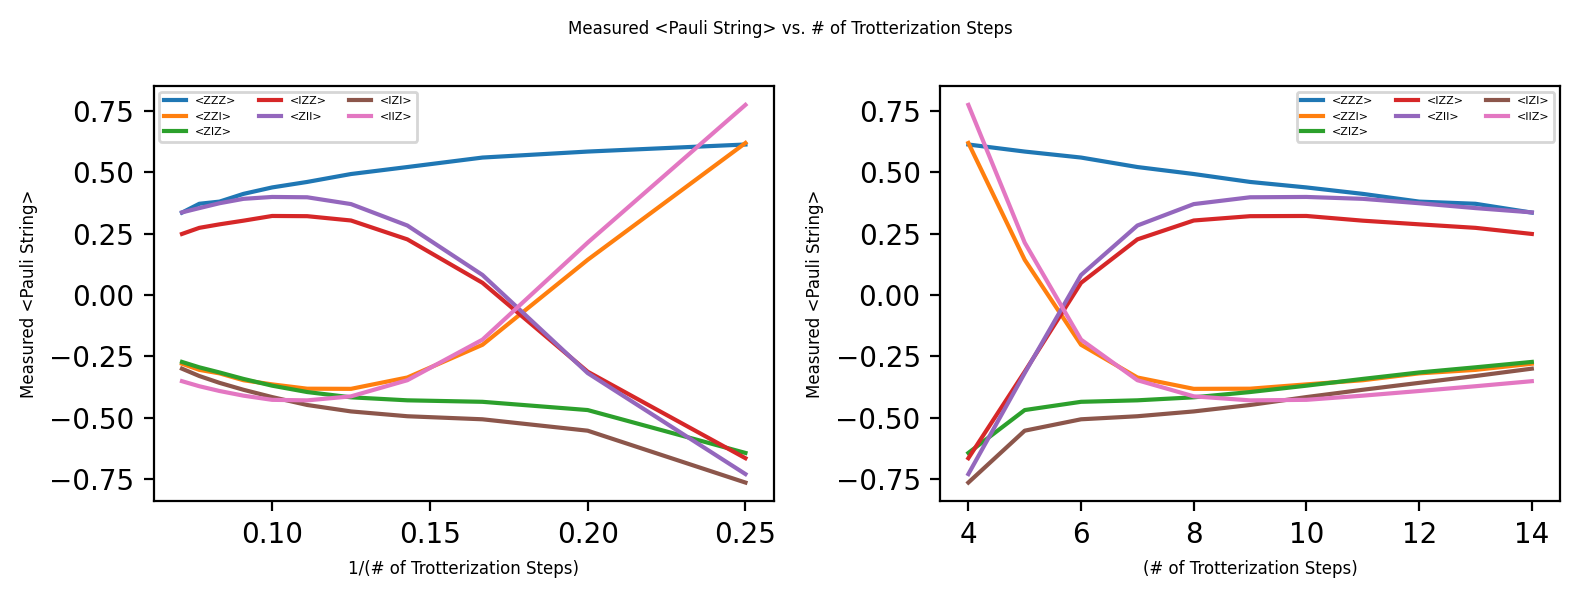

In [9]:
axs = plot_parity(res_analysis, parity_strings=["ZZZ", "ZZI", "ZIZ", "IZZ", "ZII", "IZI", "IIZ"], legend=True)

In [ ]:
gen_parity_single(res_analysis['data'][(4, 0)])

## Measurement Error Mitigation

In [10]:
import qiskit.ignis.mitigation.measurement as mc
from qiskit import execute

In [11]:
# Generate the calibration circuits
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[1, 3, 5])

job_cal = execute(meas_calibs, backend=sim_noisy_jakarta, shots=20000)
meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

IBM Jakarta Noisy Simulation Readout Fidelity: 0.9079875


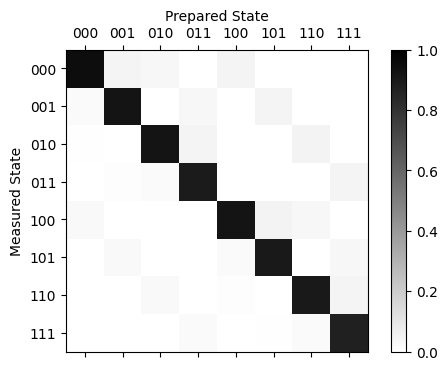

In [12]:
print(f"IBM Jakarta Noisy Simulation Readout Fidelity: {meas_fitter.readout_fidelity()}")
fig, ax = plt.subplots(dpi=100)
meas_fitter.plot_calibration(ax=ax)

In [26]:
def run_meas_calibration(results, meas_fitter=None, deepcopy=True):
    results = copy.deepcopy(results) if deepcopy else results
    print("Running Measurement Calibration:")
    for sweep_param, result in tqdm(results["data"].items()):
        if meas_fitter is not None:
            result["filtered_data"] = [
                meas_fitter.filter.apply(r, method="least_squares")
                for r in result["raw_data"]
            ]
        else:
            result["filtered_data"] = result["raw_data"]

    return results

In [27]:
results2 = run_meas_calibration(results, meas_fitter)

Running Measurement Calibration:


100%|███████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.08it/s]


In [ ]:
results2 = copy.deepcopy(results)

for key, result in results2['data'].items():

    mitigated_result = [meas_fitter.filter.apply(r) for r in result['raw_data']]
    results2['data'][key]['raw_data'] = mitigated_result

In [17]:
res_analysis2 = {}


# Hand built method for extracting counts from raw data
for key, rep_result in results2['data'].items():
    
    ct_data = {}

    for circuit in qcs[key]:
        counts = None
        
        for result in rep_result["raw_data"]:
            counts = result.get_counts(circuit)

            # should be inside for loop to sum over results?
            if counts is None:
                raise QiskitError("Result for {} not found".format(circ.name))
            if isinstance(circuit, str):
                pauli_tup = literal_eval(circuit)
            elif isinstance(circuit, QuantumCircuit):
                pauli_tup = literal_eval(circuit.name)
            else:
                pauli_tup = circuit
            
            # Change from tuple to string! 
            pauli_tup = ''.join(pauli_tup)
            
            if pauli_tup in ct_data:
                ct_data[pauli_tup] = combine_counts(ct_data[pauli_tup], counts)
            else:
                ct_data[pauli_tup] = counts
                
     
    # Convert from binary "111" to decimal "0x7"
    for pauli, counts_dict in ct_data.items():
        
        mod_counts = {}
        for bitstring, count in counts_dict.items():
            
            mod_bitstring = "0x" + str(int(bitstring, 2))
            mod_counts[mod_bitstring] = count
            
        ct_data[pauli] = mod_counts
    
    
    
    
    res_analysis2[key] = {'data_map': ct_data}

In [19]:
res_analysis2[(4, 0)]

{'data_map': {'XXX': {'0x5': 7872,
   '0x1': 8367,
   '0x6': 7930,
   '0x4': 8354,
   '0x0': 9087,
   '0x2': 8443,
   '0x7': 7537,
   '0x3': 7946},
  'XXY': {'0x1': 8372,
   '0x6': 7961,
   '0x4': 8561,
   '0x5': 7967,
   '0x7': 7615,
   '0x3': 7902,
   '0x0': 8839,
   '0x2': 8319},
  'XXZ': {'0x5': 1840,
   '0x4': 1948,
   '0x1': 14433,
   '0x6': 1897,
   '0x2': 14447,
   '0x0': 15393,
   '0x7': 1767,
   '0x3': 13811},
  'XYX': {'0x4': 8386,
   '0x6': 7962,
   '0x1': 8276,
   '0x2': 8566,
   '0x0': 8773,
   '0x7': 7608,
   '0x3': 7869,
   '0x5': 8096},
  'XYY': {'0x7': 7440,
   '0x3': 7980,
   '0x6': 7913,
   '0x1': 8470,
   '0x4': 8452,
   '0x0': 8906,
   '0x2': 8394,
   '0x5': 7981},
  'XYZ': {'0x0': 15327,
   '0x2': 14631,
   '0x5': 1862,
   '0x7': 1796,
   '0x3': 13741,
   '0x4': 1936,
   '0x6': 1833,
   '0x1': 14410},
  'XZX': {'0x3': 14339,
   '0x7': 13844,
   '0x5': 1721,
   '0x1': 1898,
   '0x4': 1942,
   '0x6': 14362,
   '0x0': 2043,
   '0x2': 15387},
  'XZY': {'0x3': 14348,


In [20]:
for key in res_analysis2.keys():
    res_analysis2[key] = gen_parity_single(res_analysis2[key])

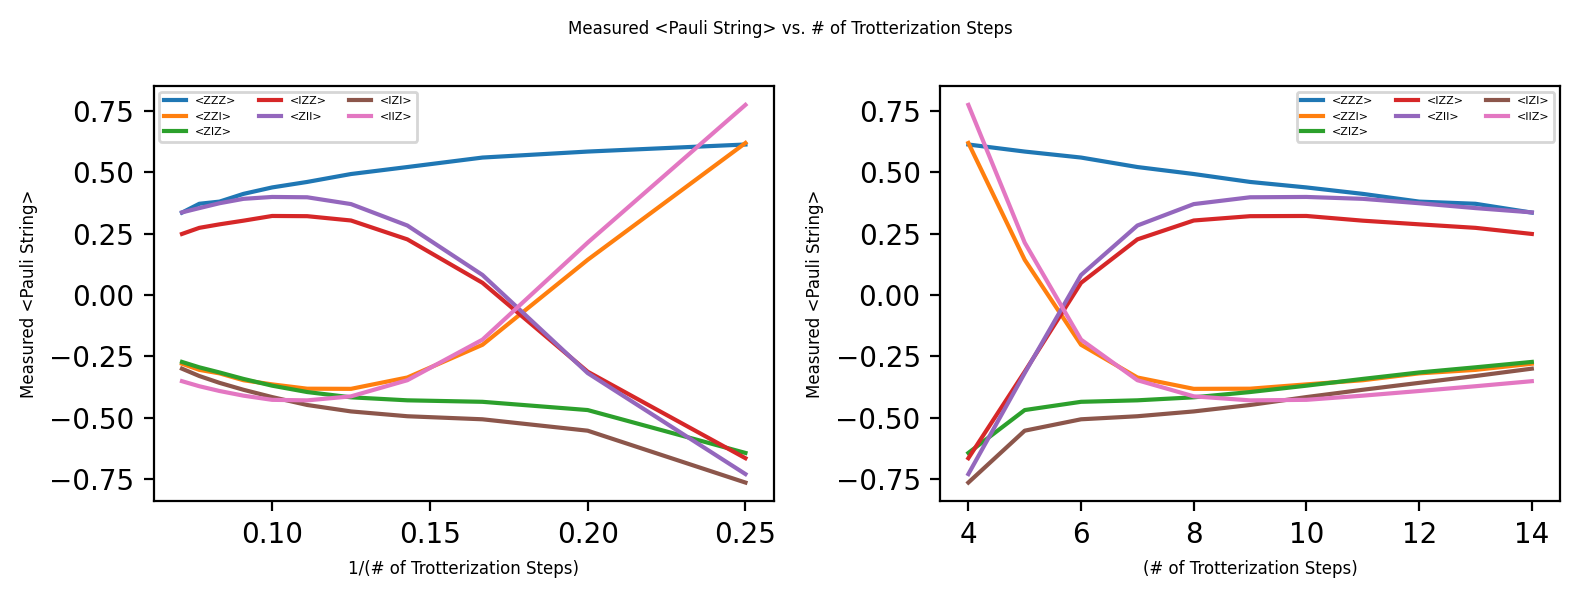

In [22]:
res_analysis3 = {'data': res_analysis2}

ax = plot_parity(res_analysis3, parity_strings=["ZZZ", "ZZI", "ZIZ", "IZZ", "ZII", "IZI", "IIZ"], legend=True)

In [28]:
res_analysis4 = run_analysis(results2, unitary_folding=False) 

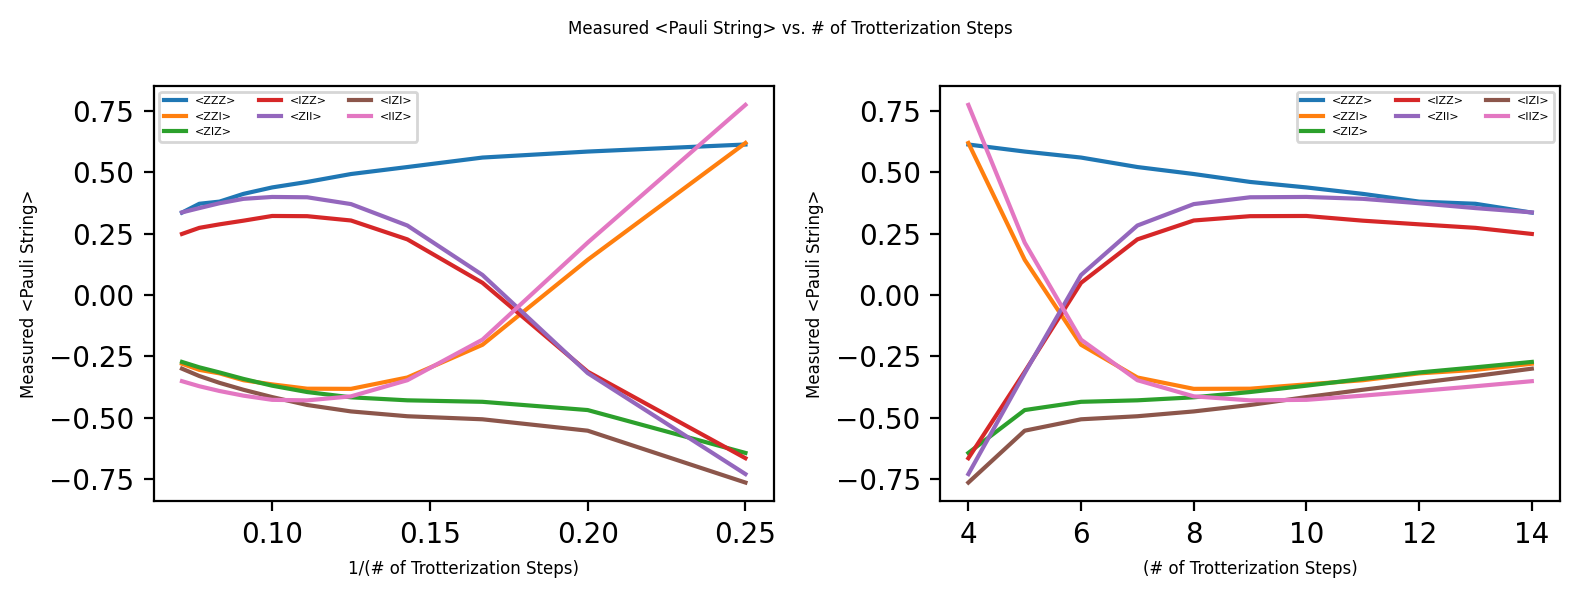

In [29]:
ax = plot_parity(res_analysis4, parity_strings=["ZZZ", "ZZI", "ZIZ", "IZZ", "ZII", "IZI", "IIZ"], legend=True)

In [ ]:
# Set key to check mitigation
KEY = (10, 0)

In [ ]:
gen_data_map_sweep(results2, deepcopy=False)
gen_parity_sweep(results2, deepcopy=False)
res_analysis2 = run_metric_analysis_sweep(results2, deepcopy=False)

In [ ]:
mitigated_results = [meas_fitter.filter.apply(r, method='least_squares') for r in res_analysis['data'][KEY]['raw_data']]

In [ ]:
mitigated_counts = mitigated_results[0].get_counts(qcs[KEY][0])

In [ ]:
raw_counts = res_analysis['data'][KEY]['raw_data'][0].get_counts(qcs[KEY][-7])

In [ ]:
from qiskit.tools.visualization import plot_histogram
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])

In [ ]:
mitigated_results[0].get_counts(qcs[(4, 0)][1])

## Tomography Comparison

In [16]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, Instruction
from qiskit.quantum_info import Pauli, DensityMatrix, Statevector, partial_trace

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography.fitters.lstsq_fit import lstsq_fit, make_positive_semidefinite
from qiskit.ignis.verification.tomography.fitters.cvx_fit import cvx_fit

from qiskit.quantum_info import state_fidelity
from qiskit.opflow import Zero, One, I, X, Y, Z

# Generate Counts Stuff
from ast import literal_eval
from qiskit import QiskitError
from qiskit import QuantumCircuit
from qiskit.ignis.verification.tomography import marginal_counts, count_keys, combine_counts
from tomography import CustomTomographyFitter

### Unmitigated

In [ ]:
# Parsing the counts ourselves, though CustomTomographyFitter can get it directly from results
def get_fid_unmitigated(key):

    ct_data = {}

    for circuit in qcs[key]:
        counts = None
        for result in res_analysis["data"][key]["raw_data"]:
            counts = result.get_counts(circuit)

            # should be inside for loop to sum over results?
            if counts is None:
                raise QiskitError("Result for {} not found".format(circ.name))
            if isinstance(circuit, str):
                pauli_tup = literal_eval(circuit)
            elif isinstance(circuit, QuantumCircuit):
                pauli_tup = literal_eval(circuit.name)
            else:
                pauli_tup = circuit
            if pauli_tup in ct_data:
                ct_data[pauli_tup] = combine_counts(ct_data[pauli_tup], counts)
            else:
                ct_data[pauli_tup] = counts
                
                
    ctf = CustomTomographyFitter(ct_data)
    rho_fit = ctf.fit(method='cvx', trace=1, psd=True)
    rho_fit = make_positive_semidefinite(rho_fit)
    rho_fit *= 1 / np.trace(rho_fit)
    
    target_state, _ = gen_target()
    return state_fidelity(rho_fit, target_state)

In [ ]:
get_fid_unmitigated(key=(14, 0))

### Mitigated

In [ ]:
def get_fid_mitigated(key):
    
    ct_data_mit = {}
    mitigated_results = [meas_fitter.filter.apply(r, method='least_squares') for r in res_analysis['data'][key]['raw_data']]

    for circuit in qcs[key]:
        counts = None
        for result in mitigated_results:
            counts = result.get_counts(circuit)

            # should be inside for loop to sum over results?
            if counts is None:
                raise QiskitError("Result for {} not found".format(circ.name))
            if isinstance(circuit, str):
                pauli_tup = literal_eval(circuit)
            elif isinstance(circuit, QuantumCircuit):
                pauli_tup = literal_eval(circuit.name)
            else:
                pauli_tup = circuit
            if pauli_tup in ct_data_mit:
                ct_data_mit[pauli_tup] = combine_counts(ct_data_mit[pauli_tup], counts)
            else:
                ct_data_mit[pauli_tup] = counts
            
    ctf_mit = CustomTomographyFitter(ct_data_mit)
    rho_fit_mit = ctf_mit.fit(method='cvx', trace=1, psd=True)
    rho_fit_mit = make_positive_semidefinite(rho_fit_mit)
    rho_fit_mit *= 1 / np.trace(rho_fit_mit)
    
    target_state, _ = gen_target()
    return state_fidelity(rho_fit_mit, target_state)
            

In [ ]:
get_fid_mitigated(key=(14, 0))

In [ ]:
mitigated_fids = [get_fid_mitigated(key=(trot_step, 0)) for trot_step in trott_steps_range]
unmitigated_fids = [get_fid_unmitigated(key=(trot_step, 0)) for trot_step in trott_steps_range]


In [ ]:
plt.figure(dpi=150)
plt.plot(trott_steps_range, mitigated_fids, label="calibrated")
plt.plot(trott_steps_range, unmitigated_fids, label="uncalibrated")
plt.legend()
plt.xlabel("Number of Trotter Steps")
plt.ylabel("State Tomography Fidelity")
plt.show()